In [58]:
import omnisafe
from tqdm import tqdm
import safety_gymnasium
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from load_model import load_guide

In [4]:
from torch import nn

class ExpectedCostRegressor(nn.Module):
    def __init__(self):
        super(ExpectedCostRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(57, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,1),
        )
    def forward(self, x):
        return self.fc(x)

class ExpectedCostClassifier(nn.Module):
    def __init__(self):
        super(ExpectedCostClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(57, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)

In [6]:
from omnisafe.models.actor import GaussianLearningActor

env = safety_gymnasium.make('SafetyPointGoal1-v0', max_episode_steps=1000)

def create_random_agent(env, hidden_layers=[255,255,255,255], activation='relu', weight_initialization_mode='orthogonal'):
    obs_space = env.observation_space
    act_space = env.action_space
    return GaussianLearningActor(obs_space, act_space, hidden_layers, activation=activation, weight_initialization_mode=weight_initialization_mode)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [19]:
classifier = torch.load("classifier.pt")
regressor = torch.load("regressor.pt")

/tmp/ipykernel_7367/504561020.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier = torch.load("classifier.pt")
/tmp/ipykernel_7367/504561020.py:2: FutureWarning:

# Normal Control-Switch

In [32]:
def cs_run(env, agent, safe_agent, classifier=None, regressor=None, cost_budget=None):
    observation, info = env.reset()
    episode_over = False
    rec = False
    step = 0
    rec_step = -1
    episode_cost = 0
    while not episode_over:
        obs_tensor = torch.from_numpy(observation).float()

        if rec:
            action = safe_agent.predict(obs_tensor, deterministic=True).detach().numpy()
        else:
            action = agent.predict(obs_tensor, deterministic=True).detach().numpy()

        observation, reward, cost, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated

        episode_cost += cost
        
        if episode_cost > 0 and not rec:
            rec = True
            rec_step = step
        
        step += 1
    env.close()
    return episode_cost, rec, rec_step

# Predictive Control-Switch

In [31]:
def pcs_run(env, agent, safe_agent, classifier, regressor=None, cost_budget=None):
    observation, info = env.reset()
    episode_over = False
    rec = False
    step = 0
    rec_step = -1
    episode_cost = 0
    while not episode_over:
        obs_tensor = torch.from_numpy(observation).float()

        if rec:
            action = safe_agent.predict(obs_tensor, deterministic=True).detach().numpy()
        else:
            action = agent.predict(obs_tensor, deterministic=True).detach().numpy()
            data = np.append(observation, action)
            # remove features not used in the model, namely "velocimeter2", "accelerometer2", "magnetometer2", "gyro0" and "gyro1"
            data = np.delete(data, [2, 5, 6, 7, 11])
            data = torch.from_numpy(data).float()
            data = data.unsqueeze(0)
            data = data.to(device)
            with torch.no_grad():
                # start recovery with the guide if the sample is classified as non-zero
                if classifier(data).item() > 0.5:
                    rec = True
                    rec_step = step

        observation, reward, cost, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated

        episode_cost += cost
        
        if episode_cost > 0 and not rec:
            rec = True
            rec_step = step
        
        step += 1
    env.close()
    return episode_cost, rec, rec_step

# Predictive Control-Switch with Cost Budget

In [36]:
def pcs_cost_budget_run(env, agent, safe_agent, classifier, regressor, cost_budget):
    observation, info = env.reset()
    episode_over = False
    rec = False
    step = 0
    rec_step = -1
    episode_cost = 0
    remaining_cost_budget = cost_budget
    while not episode_over:
        obs_tensor = torch.from_numpy(observation).float()

        if rec:
            action = safe_agent.predict(obs_tensor, deterministic=True).detach().numpy()
        else:
            action = agent.predict(obs_tensor, deterministic=True).detach().numpy()
            data = np.append(observation, action)
            # remove features not used in the model, namely "velocimeter2", "accelerometer2", "magnetometer2", "gyro0" and "gyro1"
            data = np.delete(data, [2, 5, 6, 7, 11])
            data = torch.from_numpy(data).float()
            data = data.unsqueeze(0)
            data = data.to(device)
            with torch.no_grad():
                # start recovery with the guide if the sample is classified as non-zero
                if classifier(data).item() > 0.5:
                    if regressor(data).item() > remaining_cost_budget:
                        rec = True
                        rec_step = step

        observation, reward, cost, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated

        episode_cost += cost
        
        if episode_cost > remaining_cost_budget and not rec:
            rec = True
            rec_step = step
        
        remaining_cost_budget -= cost
        
        step += 1
    env.close()
    return episode_cost, rec, rec_step

# Run experiments

In [29]:
def experiment_run(env, safe_agent, run_function, amount=100, classifier=None, regressor=None, cost_budget=None):
    data = []
    for _ in tqdm(range(amount), desc="Running experiment", unit=" run "):
        episode_cost, rec, rec_step = run_function(env, create_random_agent(env), safe_agent, classifier, regressor, cost_budget)
        data.append([episode_cost, rec, rec_step])
    return np.array(data)

In [9]:
safe_agent = load_guide("../runs/PPOLag-{SafetyPointGoal1-v0}/seed-000-2025-05-13-17-51-08", "epoch-50.pt")[1]

/home/user/bachelor/Safety-Gymnasium/load_model.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(model_path)


In [49]:
data_cs = experiment_run(env, safe_agent, cs_run, 500)

Running experiment: 100%|██████████| 500/500 [12:13<00:00,  1.47s/ run ]


In [50]:
data_pcs = experiment_run(env, safe_agent, pcs_run, 500, classifier)

Running experiment: 100%|██████████| 500/500 [13:18<00:00,  1.60s/ run ]


In [56]:
data_pcs_cost_budget = experiment_run(env, safe_agent, pcs_cost_budget_run, 500, classifier, regressor, 8)

Running experiment: 100%|██████████| 500/500 [13:12<00:00,  1.58s/ run ]


In [ ]:
df_cs = pd.DataFrame(data_cs)
df_cs.describe()

,0,1,2
count,500.000000,500.000000,500.000000
mean,30.448000,0.532000,103.796000
std,45.140477,0.499475,184.965031
min,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,-1.000000
50%,12.000000,1.000000,39.000000
75%,46.000000,1.000000,94.000000
max,266.000000,1.000000,968.000000


In [103]:
df_cs.to_pickle("cs_data.pkl")

In [53]:
df_pcs = pd.DataFrame(data_pcs)
df_pcs.describe()

,0,1,2
count,500.000000,500.000000,500.000000
mean,29.662000,0.852000,33.790000
std,42.797465,0.355456,98.487285
min,0.000000,0.000000,-1.000000
25%,0.000000,1.000000,0.000000
50%,17.500000,1.000000,2.000000
75%,45.000000,1.000000,25.000000
max,491.000000,1.000000,892.000000


In [57]:
df_pcs_cost_budget = pd.DataFrame(data_pcs_cost_budget)
df_pcs_cost_budget.describe()

,0,1,2
count,500.000000,500.000000,500.000000
mean,28.914000,0.866000,31.628000
std,38.538982,0.340993,95.618887
min,0.000000,0.000000,-1.000000
25%,0.000000,1.000000,0.000000
50%,20.000000,1.000000,1.000000
75%,45.250000,1.000000,22.000000
max,336.000000,1.000000,951.000000


In [104]:
df_pcs.to_pickle("pcs_data.pkl")

In [68]:
df_cost = pd.DataFrame({
    'Cost': np.concatenate([data_cs[:, 0], data_pcs[:,0], data_pcs_cost_budget[:,0]]),
    'Method': ['Control-Switch'] * 500 + ['Predictive Control-Switch 1'] * 500 + ['Predictive Control-Switch 2'] * 500
})

In [81]:
sns.set_theme(style="whitegrid")

/tmp/ipykernel_7367/647887774.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Method', y='Cost', data=df_cost, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)


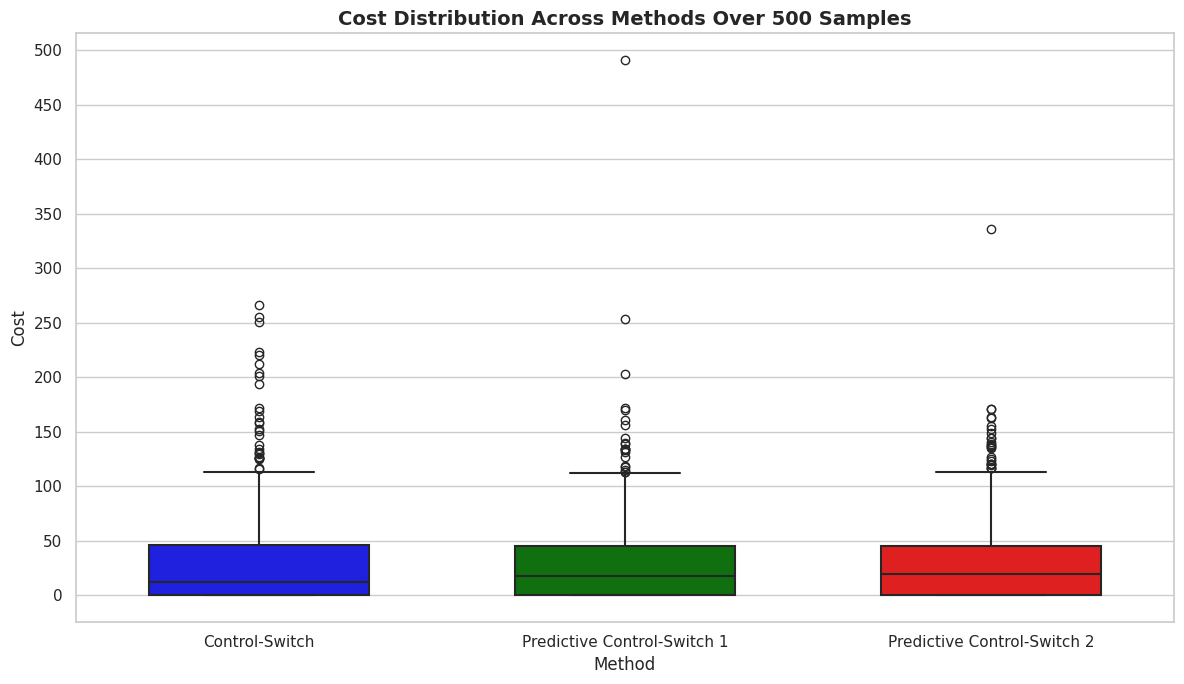

In [89]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(x='Method', y='Cost', data=df_cost, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)
ax.set_yticks(np.arange(0, 501, 50))
plt.title('Cost Distribution Across Methods Over 500 Samples', fontsize=14, weight='bold')
plt.ylabel('Cost')
plt.xlabel('Method')
plt.tight_layout()
plt.savefig("cost_comparison.png", dpi=300)
plt.show()

/tmp/ipykernel_7367/1119912632.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='Cost', data=df_cost, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)


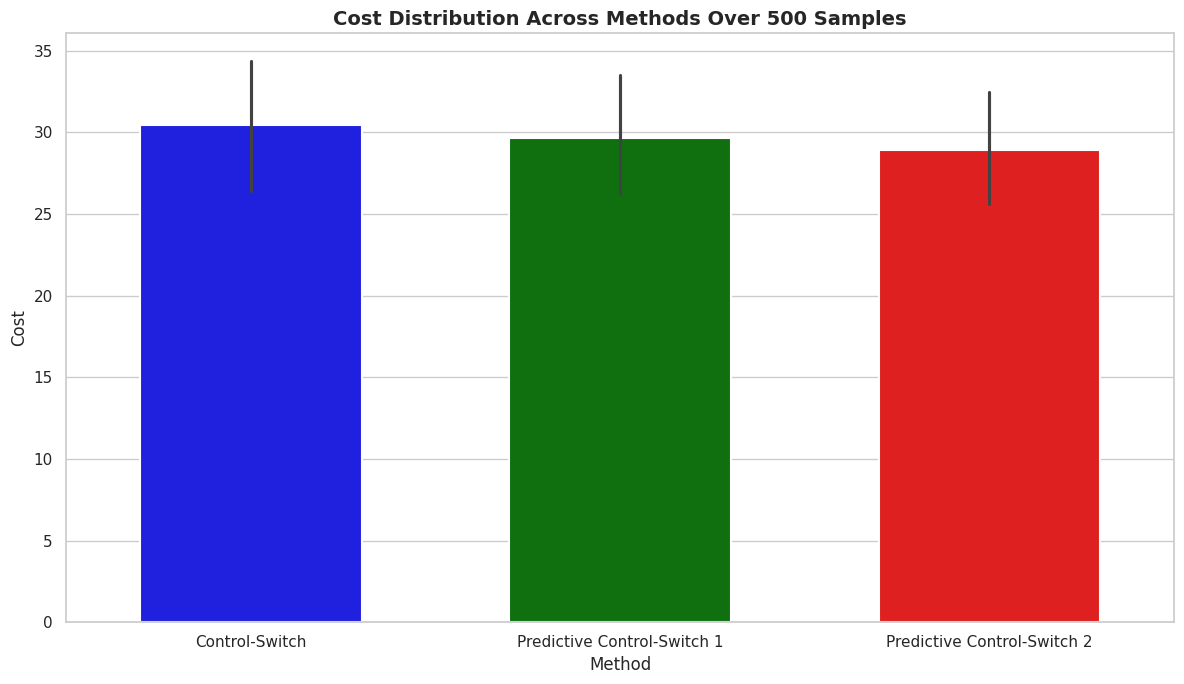

In [102]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Method', y='Cost', data=df_cost, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)
plt.title('Cost Distribution Across Methods Over 500 Samples', fontsize=14, weight='bold')
plt.ylabel('Cost')
plt.xlabel('Method')
plt.tight_layout()
plt.savefig("cost_comparison_bar.png", dpi=300)
plt.show()

In [87]:
df_rec = pd.DataFrame({
    'Cost': np.concatenate([data_cs[:, 1], data_pcs[:,1], data_pcs_cost_budget[:,1]]),
    'Method': ['Control-Switch'] * 500 + ['Predictive Control-Switch 1'] * 500 + ['Predictive Control-Switch 2'] * 500
})

/tmp/ipykernel_7367/2478618175.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='Cost', data=df_rec, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)


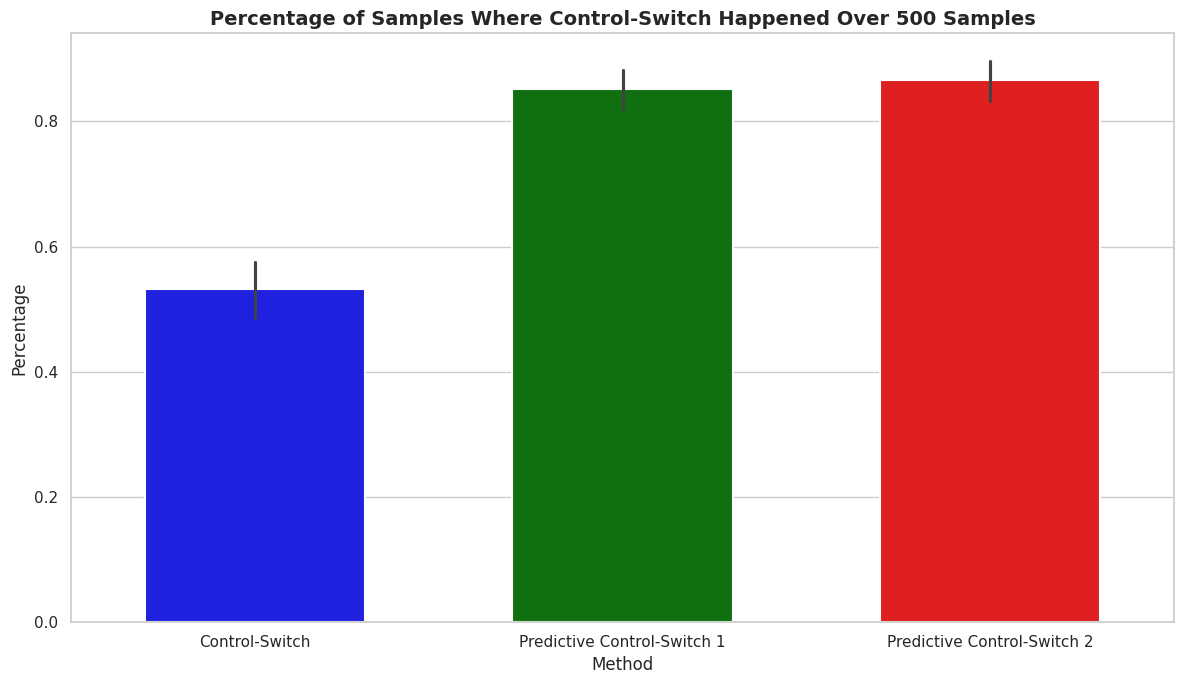

In [ ]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Method', y='Cost', data=df_rec, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)
#ax.set_yticks(np.arange(0, 501, 50))
plt.title('Percentage of Samples Where Control-Switch Happened Over 500 Samples', fontsize=14, weight='bold')
plt.ylabel('Percentage')
plt.xlabel('Method')
plt.tight_layout()
plt.savefig("rec_comparison.png", dpi=300)
plt.show()

In [93]:
df_rec_step = pd.DataFrame({
    'Cost': np.concatenate([data_cs[:, 2], data_pcs[:,2], data_pcs_cost_budget[:,2]]),
    'Method': ['Control-Switch'] * 500 + ['Predictive Control-Switch 1'] * 500 + ['Predictive Control-Switch 2'] * 500
})

/tmp/ipykernel_7367/627566465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Method', y='Cost', data=df_rec_step, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)


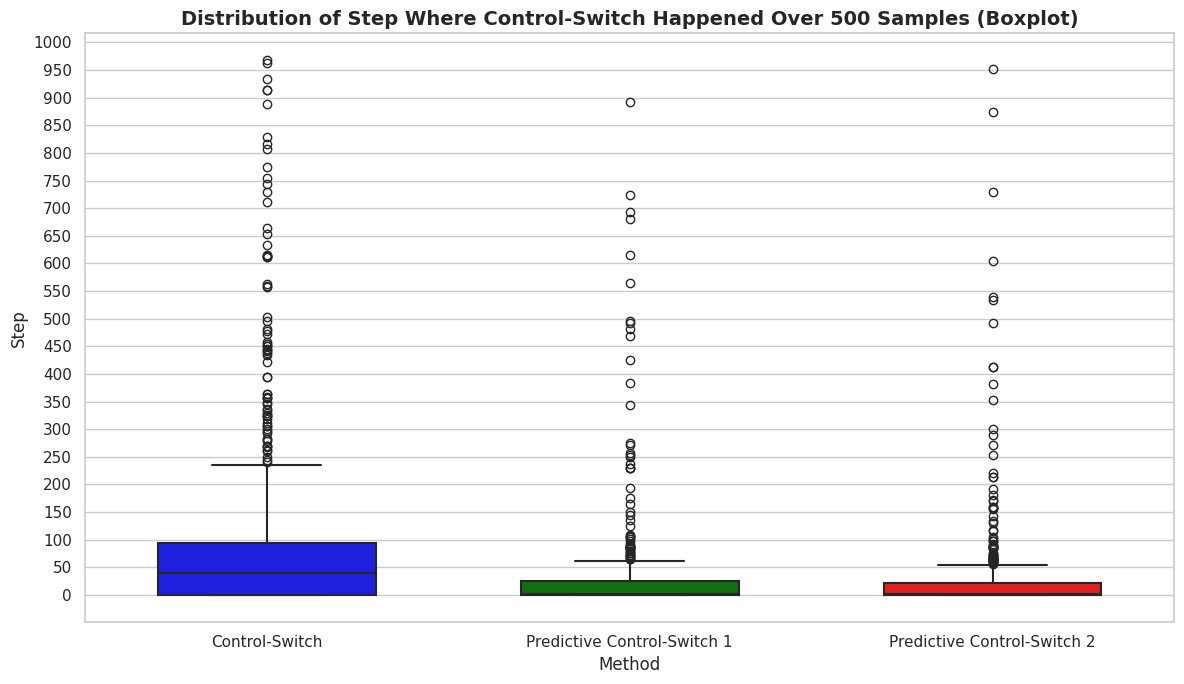

In [98]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(x='Method', y='Cost', data=df_rec_step, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)
ax.set_yticks(np.arange(0, 1001, 50))
plt.title('Distribution of Step Where Control-Switch Happened Over 500 Samples (Boxplot)', fontsize=14, weight='bold')
plt.ylabel('Step')
plt.xlabel('Method')
plt.tight_layout()
plt.savefig("rec_step_comparison_box.png", dpi=300)
plt.show()

/tmp/ipykernel_7367/1896911737.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='Cost', data=df_rec_step, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)


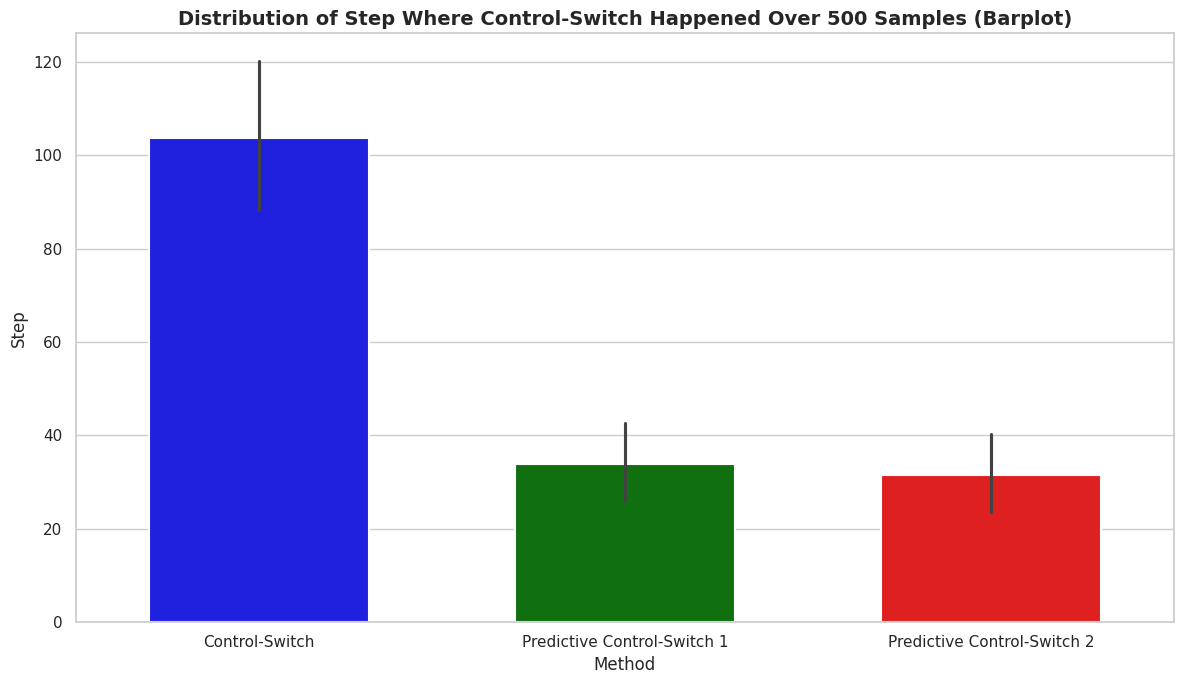

In [100]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Method', y='Cost', data=df_rec_step, palette=['blue', 'green', 'red'], width=0.6, linewidth=1.5)
plt.title('Distribution of Step Where Control-Switch Happened Over 500 Samples (Barplot)', fontsize=14, weight='bold')
plt.ylabel('Step')
plt.xlabel('Method')
plt.tight_layout()
plt.savefig("rec_step_comparison_bar.png", dpi=300)
plt.show()